# モデル動作確認

In [1]:
import torch
import torchvision
import PIL
import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform_train = torchvision.transforms.Compose([
     torchvision.transforms.RandomCrop(224),
     torchvision.transforms.RandomHorizontalFlip(0.5),
     torchvision.transforms.RandomAffine(45),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_valid = torchvision.transforms.Compose([
     torchvision.transforms.CenterCrop(224),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



class ImageLoader(torch.utils.data.Dataset):
    def __init__(self, train_fpath: str, class_fpath: str, transform: str=None) -> None:
        
        # load training image data
        with open(train_fpath, 'r') as trainfh:
            x = []
            y = []
            for line in trainfh:
                words = line.rstrip().split('\t')
                x.append(words[0])
                y.append(words[1])
        
        # load class labels
        with open(class_fpath, 'r') as classfh:
            classes = {}
            for line in classfh:
                words = line.rstrip().split('\t')
                classes[words[0]] = words[1]
        
        # save data to the private variables
        self.x = x
        self.y = y
        self.classes = classes
        self.transform = transform


    def __getitem__(self, i):
        img = PIL.Image.open(self.x[i]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)    
        label = int(self.classes[self.y[i]])
        return img, label


    def __len__(self):
        return len(self.x)
    

train_txt_fpath = '/home/lecturer01/es2023hacking/model_dev/train.txt'
train_txt_fpath = '/home/lecturer01/es2023hacking/model_dev/train.10k.txt'
class_txt_fpath = '/home/lecturer01/es2023hacking/model_dev/class_labels.txt'

# training dataset
trainset = ImageLoader(train_txt_fpath, class_txt_fpath, transform_train)

print(len(trainset))
print(len(trainset.classes))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

/home/lecturer01/miniconda3/envs/prj1/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


10000
4


In [2]:
net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
num_ftrs = net.fc.in_features
net.fc = torch.nn.Linear(num_ftrs, len(trainset.classes))

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
net.train()
net = net.to(device)

for epoch in range(10):
    
    running_loss = 0.0
    n_correct = 0
    n_total = 0
  
    for inputs, labels in tqdm.tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        res = (predicted == labels)
        res = res.sum().item()
        n_correct = n_correct + res
        n_total = n_total + len(labels)

        loss = criterion(outputs, labels)
        running_loss +=  loss.item()

        loss.backward()
        optimizer.step()
        
    print([running_loss, n_correct / n_total])
  

100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:50<00:00,  1.84it/s]


[384.5678715109825, 0.4467]


100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:55<00:00,  1.79it/s]


[344.4044067263603, 0.5197]


100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:46<00:00,  1.88it/s]


[314.3660519719124, 0.5773]


100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:50<00:00,  1.83it/s]


[301.3131369948387, 0.5951]


100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:49<00:00,  1.85it/s]


[288.4346916973591, 0.6144]


100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:47<00:00,  1.87it/s]


[274.88126051425934, 0.6422]


100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:46<00:00,  1.88it/s]


[268.57151532173157, 0.6523]


100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:47<00:00,  1.87it/s]


[257.4577202498913, 0.6673]


100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:45<00:00,  1.89it/s]


[251.46172672510147, 0.6738]


100%|█████████████████████████████████████████████████████████████████████████| 313/313 [02:46<00:00,  1.88it/s]

[244.123707562685, 0.6808]


In [11]:
net.eval()

n_correct = 0
n_total = 0


valid_txt_fpath = '/home/lecturer01/es2023hacking/model_dev/valid.100.txt'
class_txt_fpath = '/home/lecturer01/es2023hacking/model_dev/class_labels.txt'

validset = ImageLoader(valid_txt_fpath, class_txt_fpath, transform_valid)

print(len(validset))
print(len(validset.classes))

validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=True)


for data in validloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = net(inputs)

    _, predicted = torch.max(outputs.data, 1)
    
    res = (predicted == labels)
    res = res.sum().item()

    n_correct = n_correct + res
    n_total = n_total + len(labels)

val_acc = n_correct / n_total
print(val_acc)

100
4
0.63


In [5]:
net = net.to('cpu')
torch.save(net.state_dict(), 'resnet18_weights.pth')

tensor([[-0.4406, -1.7508,  3.0782, -0.4024]], grad_fn=<AddmmBackward0>)
{'キュウリ': '0', 'ナス': '1', 'トマト': '2', 'イチゴ': '3'}
[[0.0277376  0.00748273 0.9359621  0.02881763]]


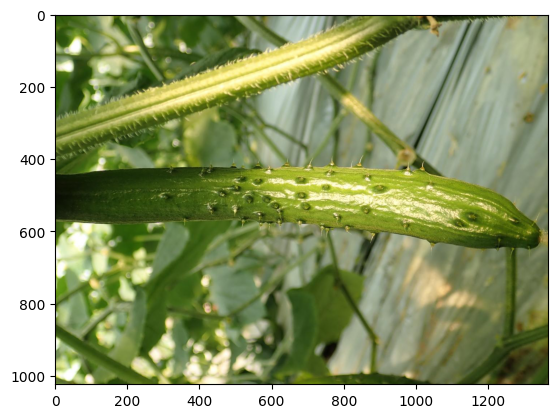

In [12]:
app = torchvision.models.resnet18(weights=None)
num_ftrs = app.fc.in_features
app.fc = torch.nn.Linear(num_ftrs, len(trainset.classes))
app.load_state_dict(torch.load('resnet18_weights.pth'))
app.eval()


import PIL
import numpy as np
import matplotlib.pyplot as plt

img_path = '/data/workshop1/pdbidb_1k/ナス/葉（表）/ネギアザミウマ/241108_20191021113905_01.JPG'
img_path = '/data/workshop1/pdbidb_1k/イチゴ/花/ネギアザミウマ/285017_20200305110722_01.JPG'
img_path = '/data/workshop1/pdbidb_1k/トマト/地際部/健全/529419_20201014133606_01.JPG'
img_path = '/data/workshop1/pdbidb_1k/キュウリ/果実/健全/390030_20190108135752_01.JPG'

im = PIL.Image.open(img_path)
plt.imshow(np.asarray(im))
def image_loader(image_path):
    im = PIL.Image.open(image_path)
    im = transform_valid(im)
    im = im.unsqueeze(0)
    return im

x = image_loader(img_path)
output = app(x)

print(output)
print(trainset.classes)

prob1 = torch.softmax(output, dim=1).detach().numpy().copy()
print(prob1)
